In [103]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from os import path

In [97]:
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

Using CPU


In [98]:
PATH = "./TrainingData/"
val_subject = 5
test_subject = 6

In [99]:
files = []
for filename in os.listdir(PATH):
    files.append(filename)
files = sorted(files, key = lambda x: (int(x.split('_')[1]),int(x.split('_')[2]), x.split('_')[4] ))
files_train = list(filter(lambda x: int(x.split('_')[1]) not in  [val_subject, test_subject], files))
files_val = list(filter(lambda x: int(x.split('_')[1]) == val_subject, files))
files_test = list(filter(lambda x: int(x.split('_')[1])== test_subject, files))

Calculating the value count of the window (15) to feed it in CNN

In [100]:
def windows(d, w, t):
  r = np.arange(len(d))
  s = r[::t]
  z = list(zip(s, s + w))
  f = '{0[0]}:{0[1]}'.format
  g = lambda t: d.iloc[t[0]:t[1]]
  ranges = list(map(f,z))
  return ranges, pd.concat(map(g, z), keys=map(f, z))

In [101]:
def make_dataset(files, X, Y, freq_down=True, flag = False):

    overlap = 15
    if flag:
        overlap = 30

    for i in range(0, len(files), 4):
        x_time, x, y_time, y = files[i: i + 4]
        train_df = None
        if freq_down:
            #X_features
            x_time_df = pd.read_csv(PATH + x_time , header=None)
            x_df = pd.read_csv(PATH + x , header=None)
            x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
            x_combined = x_combined.loc[range(1,len(x_combined), 4)].reset_index()  # down sampled the frequency

            #Y_labels
            y_time_df = pd.read_csv(PATH + y_time , header=None)
            y_df = pd.read_csv(PATH + y , header=None)
            y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)

            train_df = pd.concat([x_combined, y_combined], axis=1, ignore_index=True)
            train_df = train_df.drop(columns=[0, 1, 8])  # Dropping the time stamp
            ranges, windows_df = windows(train_df, 30, overlap)
            for ran in ranges:
                l,r = ran.split(':')
                df_range = windows_df.iloc[int(l): int(r)]
                if int(r) > len(windows_df):
                    break
                y_values = df_range[9].values
                x_values = df_range.drop(columns=[9]).values
                X.append(x_values)
                Y.append(Counter(list(y_values)).most_common(1)[0][0])
        else:
            #X_features
            x_time_df = pd.read_csv(PATH + x_time, header=None)
            x_time_df.astype('float64')
            x_df = pd.read_csv(PATH + x, header=None)
            x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
            x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
            x_combined.set_index('timestamp', inplace=True)

            #Y_labels
            y_time_df = pd.read_csv(PATH + y_time , header=None)
            y_time_df.astype('float64')
            y_df = pd.read_csv(PATH + y, header=None)
            y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
            y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
            y_combined.set_index('timestamp', inplace=True)
            train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the neareset values
            ranges, windows_df = windows(train_df, 30, overlap)
            for ran in ranges:
                l,r = ran.split(':')
                df_range = windows_df.iloc[int(l): int(r)]
                if int(r) > len(windows_df):
                    break
                y_values = df_range['1_y'].values
                x_values = df_range.drop(columns=['1_y']).values
                X.append(x_values)
                Y.append(Counter(list(y_values)).most_common(1)[0][0])
    print(len(X), len(y))
    return X, Y

In [56]:
train_X, train_y = [], []
valid_X, valid_y = [], []
test_X, test_y = [], []

make_dataset(files_train, train_X, train_y, freq_down=False, flag=False)
train_X, train_y = np.array(train_X), np.array(train_y)
make_dataset(files_val, valid_X, valid_y, freq_down=False, flag=False)
valid_X, valid_y = np.array(valid_X),np.array(valid_y)
make_dataset(files_train, test_X, test_y, True)
test_X, test_y = np.array(test_X), np.array(test_y)
print("Done splitting the data")

70235 21
9035 21
17566 21
Done splitting the data


In [35]:
train_X.shape

(80424, 30, 6)

The weights that compensate for the imbalance distributions

In [57]:
weight  = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = np.array(train_y))
weight = torch.tensor(weight)

In [37]:
weight

tensor([0.3500, 4.8460, 9.5515, 1.2022], dtype=torch.float64)

In [58]:
from torch.nn.modules import dropout
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv1d(6,16,3)
    self.conv2 = nn.Conv1d(16,32,3)
    self.pool1 = nn.MaxPool1d(2,2)
    self.conv3 = nn.Conv1d(32,64,3)
    self.conv4 = nn.Conv1d(64,128,3)
    self.pool2 = nn.MaxPool1d(2,2)
    self.fc1 = nn.Linear(512, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)

  def forward(self, x):
    x = F.relu(self.conv1(x.permute(0,2,1)))
    x = self.pool1(F.relu(self.dropout1(self.conv2(x))))
    x = F.relu(self.conv3(x))
    x = self.pool2(F.relu(self.dropout1(self.conv4(x))))
    # print("1",x.shape)
    # x = x.view(-1,3456)
    x = torch.flatten(x,1)
    # print("2",x.shape)
    x = F.relu(self.dropout1(self.fc1(x)))
    x = F.relu(self.dropout1(self.fc2(x)))
    # print("3", x.shape)
    x = self.fc3(x)
    return x

model = Net()

In [59]:
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [60]:
batch_size = 32
x_train_loader = torch.utils.data.DataLoader(train_X,batch_size = batch_size)
y_train_loader = torch.utils.data.DataLoader(train_y,batch_size = batch_size)

x_validation_loader = torch.utils.data.DataLoader(valid_X, batch_size = batch_size)
y_validation_loader = torch.utils.data.DataLoader(valid_y, batch_size = batch_size)


x_test_loader = torch.utils.data.DataLoader(test_X, batch_size = batch_size)
y_test_loader = torch.utils.data.DataLoader(test_y, batch_size = batch_size)

Epoch: 1 	Training Loss: 1.056123 	Validation Loss: 0.735998
Validation loss decreased (inf --> 0.735998).  Saving model ...
Epoch: 2 	Training Loss: 0.876641 	Validation Loss: 0.692021
Validation loss decreased (0.735998 --> 0.692021).  Saving model ...
Epoch: 3 	Training Loss: 0.781384 	Validation Loss: 0.694409
Epoch: 4 	Training Loss: 0.744691 	Validation Loss: 0.654915
Validation loss decreased (0.692021 --> 0.654915).  Saving model ...
Epoch: 5 	Training Loss: 0.707638 	Validation Loss: 0.684610
Epoch: 6 	Training Loss: 0.650992 	Validation Loss: 0.697047
Epoch: 7 	Training Loss: 0.616478 	Validation Loss: 0.551903
Validation loss decreased (0.654915 --> 0.551903).  Saving model ...
Epoch: 8 	Training Loss: 0.587022 	Validation Loss: 0.567680
Epoch: 9 	Training Loss: 0.556400 	Validation Loss: 0.576241
Epoch: 10 	Training Loss: 0.532579 	Validation Loss: 0.593256


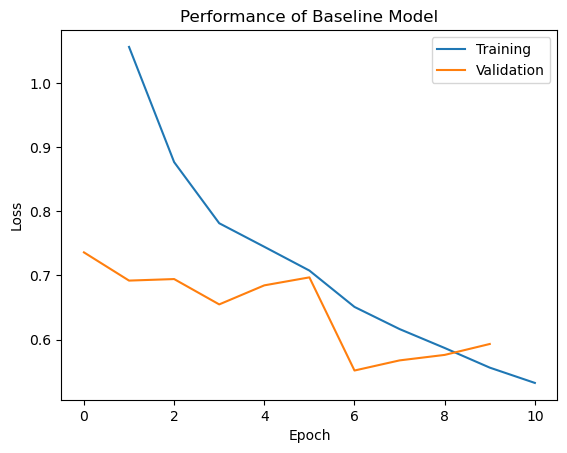

In [61]:
import matplotlib.pyplot as plt

n_epochs = 10

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):

  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss
  for epoch in range(1, n_epochs + 1):
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
    
      model.train()

      for data,target in zip(x_train_loader,y_train_loader):
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          optimizer.zero_grad()
          output = model(data.float())
          output = output.float()
          target = target.type(torch.LongTensor)
          
          if flag_cuda:
            output, target = output.cuda(), target.cuda()

          loss = criterion(output, target)

          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      model.eval()

      for data,target in zip(x_validation_loader,y_validation_loader):
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data.float())
          output = output.float()
          target = target.type(torch.LongTensor) 

          if flag_cuda:
            output, target = output.cuda(), target.cuda()

          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/len(train_X)
      valid_loss = valid_loss/len(valid_X)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      #Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
        
  return train_losslist, valid_losslist

# Executing the training
train_losslist, valid_losslist = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model.pt'))

# Plotting the learning curves
plt.plot(range(1, n_epochs + 1), train_losslist, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

In [68]:
classes = [0.,1.,2.,3.]
y_prediction = []

def assessNet(model,criterion, x_test_loader, y_test_loader):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(4))
  class_total = list(0. for i in range(4))

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data

  print(valid_X.shape)

  for data,target in zip(x_test_loader,y_test_loader):
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data.float())
      # output = torch.argmax(output,dim = 1)
      output = output.float()
      # output = torch.tensor(np.argmax(output.detach().numpy(),axis=1))
      target = target.type(torch.LongTensor) 
      # target = target.float()
      if flag_cuda:
        output, target = output.cuda(), target.cuda()
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      # print(pred)
      y_prediction.extend(pred.cpu().numpy())
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # Calculating test accuracy for each object class
      for i in range(len(output)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(valid_X)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))


  return

assessNet(model,criterion, x_test_loader, y_test_loader)

(9035, 30, 6)
Test Loss: 2.064366

Test Accuracy of        0.0: 95% (11848/12401)
Test Accuracy of        1.0: 23% (207/895)
Test Accuracy of        2.0:  0% ( 0/452)
Test Accuracy of        3.0:  7% (280/3818)

Test Accuracy (Overall): 70% (12335/17566)


In [60]:
len(y_prediction)

1128

In [65]:

print(classification_report(y_true=test_y, y_pred=y_prediction))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83     12401
           1       0.49      0.23      0.31       895
           2       0.00      0.00      0.00       452
           3       0.29      0.07      0.12      3818

    accuracy                           0.70     17566
   macro avg       0.38      0.32      0.32     17566
weighted avg       0.61      0.70      0.63     17566



In [62]:
print(confusion_matrix(y_true=valid_y, y_pred=y_prediction))

[[921   3   2   7]
 [  1  43   0   0]
 [  4   8  23  21]
 [ 93   0   0   2]]


Evaluating on test data

In [121]:
test_path = "./TestData/"
target_path = "./output"
test_overlap = 30
test_files = sorted(os.listdir(test_path))
for i in range(0, len(test_files), 3):
    X = []
    x_time, x, y_time = test_files[i: i + 3]
    train_df = None
    
    #X_features
    x_time_df = pd.read_csv(test_path + x_time , header=None)
    x_df = pd.read_csv(test_path + x , header=None)
    x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
    x_combined = x_combined.loc[range(1,len(x_combined), 4)].reset_index()  # down sampled the frequency
    y_time_df = pd.read_csv(test_path + y_time , header=None)
    # train_df = pd.concat([x_combined, y_combined], axis=1, ignore_index=True)
    train_df = x_combined.drop(columns=[0, 1])  # Dropping the time stamp
    ranges, windows_df = windows(train_df, 30, test_overlap)
    for ran in ranges:
        l,r = ran.split(':')
        df_range = windows_df.iloc[int(l): int(r)]
        if int(r) > len(windows_df):
            break
        x_values = df_range.values
        X.append(x_values)
    X = np.array(X)
    x_test_loader = torch.utils.data.DataLoader(X, batch_size = len(X))
    total_pred = []
    for data in x_test_loader:
        pred = model(data.float())
        pred = np.argmax(pred.detach().numpy(), axis=1)
        for target in pred:
            total_pred.extend([target] * 30)
        remaining = len(train_df) - len(total_pred)
        if remaining:
            total_pred.extend([total_pred[-1]] * remaining)

        y_df = pd.DataFrame(total_pred)
        filename = path.join(target_path,(x_time.split('__')[0] + '__y.csv'))
        y_df.to_csv(filename, index=False, header=None)
    